In [1]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets.mpr_dataset import MPR_Dataset
from tqdm import tqdm
import yaml
import pandas as pd
import numpy as np
from models import ShuffleNetv2
from sklearn.metrics import accuracy_score, f1_score
from ast import literal_eval
# from visualize_results import label_predictions_to_images
import os
import cv2
import copy
import matplotlib.pyplot as plt

In [3]:
with open('./config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config['device'] = 'cpu'
root_dir = config["data"]["root_dir"]
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = MPR_Dataset(root_dir, partition="train", config=config["data"], transform=transform)

test_loader = DataLoader(
    MPR_Dataset(root_dir, partition="test", config=config["data"], transform=transform), shuffle=False,
    batch_size=32)

1
1


In [4]:
device = torch.device("cuda:0")
model = ShuffleNetv2(n_classes=3)
# PATH_WEIGHTS = '/home/petryshak/CoronaryArteryPlaqueIdentification/experiments/exp2/models/'
PATH_WEIGHTS = 'model_model_34_val_f1=0.9360136.pth'
# model.load_state_dict(torch.load(PATH_WEIGHTS, map_location={'cuda:0': 'cpu'}))
model.load_state_dict(torch.load(PATH_WEIGHTS))
model.to(device)
model.eval()

ShuffleNetv2(
  (model): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNo

In [5]:
# sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
predictions = [] 

for step, (x, y) in tqdm(enumerate(test_loader)):
    x = x.to(device)
    y = y.to(device)
    output = model(x)
    _, predicted = torch.max(output, 1)
    predictions.extend(predicted.cpu().detach().numpy())

760it [03:14,  3.90it/s]


In [7]:
len(predictions)

24300

In [8]:
p_test_df = pd.read_csv("/home/petryshak/CoronaryArteryPlaqueIdentification/data/all_branches_with_pda_plv/test/labels.csv")

p_test_df = p_test_df[p_test_df['MPR_VIEWPOINT_INDEX']%1 == 0].reset_index()
p_test_df['PRED'] = pd.Series(predictions)
p_test_df["STENOSIS_SCORE"] = p_test_df["STENOSIS_SCORE"].apply(literal_eval)
p_test_df['PATIENT'] = p_test_df['IMG_PATH'].apply(lambda s: s.split('/')[1])
mapper = {}
for group, values in config['data']['groups'].items():
    for value in values:
        mapper[value] = group
p_test_df["LABELS"] = p_test_df["STENOSIS_SCORE"].apply(lambda x: max([mapper[el] for el in x])).tolist()

In [9]:
p_test_df.to_csv('WIMLsubmitted_predictions.csv', index=False)

In [2]:
p_test_df = pd.read_csv('WIMLsubmitted_predictions.csv')
df = p_test_df.iloc[::50, :]
df.shape

(486, 9)

In [3]:
df['STENOSIS'] = df['STENOSIS_SCORE'].apply(lambda x: str(x)[1:-1])

/home/maria/cad/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Visualize

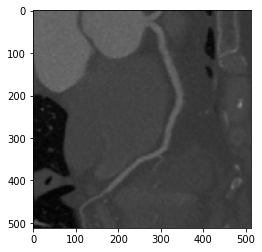

In [7]:
partition = 'test'
p_data = '/home/petryshak/CoronaryArteryPlaqueIdentification/data/data_/all_branches_with_pda_plv/{}/'.format(partition)
path_save = './result/'

folder_imag = path_save  + '/imgs'
folder_imag_correct =  path_save + 'correct'
folder_imag_mistakes = path_save + 'mistakes'
if not os.path.exists(folder_imag):
    os.mkdir(folder_imag)
if not os.path.exists(folder_imag_correct):
    os.mkdir(folder_imag_correct)
if not os.path.exists(folder_imag_mistakes):
    os.mkdir(folder_imag_mistakes)

for index,a in df.iterrows():
    im_name = p_data + a['IMG_PATH']
    img = cv2.imread(im_name)
    plt.imshow(img)
    
    label_text = 'Label:       ' + str(a['LABELS']) + '  stenosis: ' + str(a['STENOSIS']) 
    pred_text = 'Prediction: ' + str(a['PRED']) 
    
    font = cv2.FONT_HERSHEY_COMPLEX
    new_img = copy.deepcopy(img)
    cv2.putText(new_img, label_text,(30,470), font, 0.4,(255,255,255),1,cv2.LINE_AA)
    cv2.putText(new_img, pred_text,(30,490), font, 0.4,(255,255,255),1,cv2.LINE_AA)
    
    if a['LABELS'] == a['PRED']:
        cv2.imwrite( os.path.join(folder_imag_correct, str(index)+'.png'), new_img )
    else:
        cv2.imwrite( os.path.join(folder_imag_mistakes, str(index)+'.png'), new_img ) 

In [202]:
# dict_artery = {'LAD': ['D-1', 'D-2', 'LAD', 'D-3', '2D-2', 'D-1Original', 'LADOriginal', 'D-4'],
#                    'LCX': ['LCX', 'OM-2', 'OM-1', 'OM-3', 'OM', 'LCX-PLB', 'LCX-PDA', 'PLV_LCX', 'PDA_LCX'],
#                    'RCA': ['RCA', 'RCA-PLB', 'RCA-PDA', 'PLV_RCA']}
    
# p_test_df['artery'] = p_test_df['ARTERY_SECTION'].apply(lambda x: [k for k in dict_artery.keys() if x in dict_artery[k]][0])

In [11]:
p_test_df.groupby('ARTERY_SECTION').count().LABELS

ARTERY_SECTION
D-1        4950
D-2        2400
D-3         150
LAD        5250
LCX        4150
OM          100
OM-1        750
OM-2       1850
OM-3        200
PDA_LCX      50
PLV_LCX      50
PLV_RCA    4050
RCA         350
Name: LABELS, dtype: int64

In [12]:
def calculate_metrics(col_section, col_ids, col_preds, col_labels):
    """
    Calculate final auc and f1 metrics on three levels: per patient, per section and per artery
    :return: {dict} each metric as a key and its calculated metric as a value
    """
    assert len(col_section) == len(col_ids) == len(col_preds) == len(col_labels)

    metrics = {'ACC_section': 0, 'ACC_patient': 0, 'ACC_artery': 0, 'F1_section': 0, 'F1_patient': 0, 'F1_artery': 0}
    dict_artery = {'LAD': ['D-1', 'D-2', 'LAD', 'D-3', '2D-2', 'D-1Original', 'LADOriginal', 'D-4'],
                   'LCX': ['LCX', 'OM-2', 'OM-1', 'OM-3', 'OM', 'LCX-PLB', 'LCX-PDA', 'PLV_LCX', 'PDA_LCX'],
                   'RCA': ['RCA', 'RCA-PLB', 'RCA-PDA', 'PLV_RCA']}
    
    df = pd.concat([col_ids, col_section, col_preds, col_labels], axis=1)
    df = df.rename(columns={col_section.name: 'section', col_ids.name: 'patient', col_preds.name:
        'preds', col_labels.name: 'labels'})
    df['artery'] = df['section'].apply(lambda x: [k for k in dict_artery.keys() if x in dict_artery[k]][0])

    # SECTION
    section_labels =  df[['preds', 'labels','section', 'artery','patient']].groupby(['patient', 'section']).agg(lambda x: max(x))
    preds_section = df[['preds', 'labels','section','artery', 'patient']].groupby(['patient', 'section']).agg(lambda x: x.value_counts().index[0])
    acc = accuracy_score(preds_section['preds'], section_labels['labels'])
    f1 = f1_score(preds_section['preds'], section_labels['labels'], average='weighted')
    metrics['ACC_section'], metrics['F1_section'] = acc, f1

    # ARTERY
    sect = section_labels.reset_index()
    artery_labels = sect.groupby(['patient', 'artery']).agg(lambda x: max(x))['labels']
    preds_artery = preds_section.reset_index().groupby(['patient', 'artery']).agg(lambda x: max(x) )['preds'] #x.value_counts().index[0])['preds']
    acc = accuracy_score(preds_artery, artery_labels)
    f1 = f1_score(preds_artery, artery_labels, average='weighted')
    metrics['ACC_artery'], metrics['F1_artery'] = acc, f1
    
    # PATIENT
    art = artery_labels.reset_index()
    patient_labels = art.groupby(['patient']).agg(lambda x: max(x))['labels']    
#     print(preds_artery.reset_index())
    preds_patient = preds_artery.reset_index().groupby(['patient']).agg(lambda x: max(x) )['preds'] #x.value_counts().index[0])['preds']
    acc = accuracy_score(preds_patient, patient_labels)
    f1 = f1_score(preds_patient, patient_labels, average='weighted')
    metrics['ACC_patient'], metrics['F1_patient'] = acc, f1
    
    return metrics


In [205]:
"""OHEM: RECALL model_model_8_val_recall=0.551746.pth"""
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.7922535211267606,
 'ACC_patient': 0.7428571428571429,
 'ACC_section': 0.7921810699588477,
 'F1_artery': 0.7931451906248129,
 'F1_patient': 0.7407340485601355,
 'F1_section': 0.7906829687520956}

In [197]:
"""new_result_cross_entropy.pth"""
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.7852112676056338,
 'ACC_patient': 0.7428571428571429,
 'ACC_section': 0.8045267489711934,
 'F1_artery': 0.790260757262212,
 'F1_patient': 0.7443554028566115,
 'F1_section': 0.8111830846183204}

In [179]:
"""CrossEntropy: RECALL model_model_3_val_recall=0.568254"""
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.7887323943661971,
 'ACC_patient': 0.7428571428571429,
 'ACC_section': 0.8065843621399177,
 'F1_artery': 0.7905444945404247,
 'F1_patient': 0.741420715969027,
 'F1_section': 0.809236972038155}

In [172]:
"""OHEM: RECALL model_model_3_val_recall=0.568254"""
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.721830985915493,
 'ACC_patient': 0.6,
 'ACC_section': 0.7304526748971193,
 'F1_artery': 0.7116879867839019,
 'F1_patient': 0.634249684741488,
 'F1_section': 0.7192057923947303}

In [166]:
"""model_model_5_val_recall=0.5493651.pth"""
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.7676056338028169,
 'ACC_patient': 0.7047619047619048,
 'ACC_section': 0.7654320987654321,
 'F1_artery': 0.765664176773691,
 'F1_patient': 0.7021960896097714,
 'F1_section': 0.7625994556523691}

In [160]:
"""OHEM: RECALL model_model_4_val_recall=0.5263492.pth"""
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.7640845070422535,
 'ACC_patient': 0.6761904761904762,
 'ACC_section': 0.7613168724279835,
 'F1_artery': 0.7643554265609628,
 'F1_patient': 0.67910592808552,
 'F1_section': 0.7604900955788793}

In [151]:
"""model_model_34_val_f1=0.9360136.pth"""
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.8169014084507042,
 'ACC_patient': 0.7904761904761904,
 'ACC_section': 0.808641975308642,
 'F1_artery': 0.819036436847041,
 'F1_patient': 0.7897633598646553,
 'F1_section': 0.8119016363789144}

In [13]:
"""model_model_34_val_f1=0.9360136.pth  ||| FOR EVERY IMAGE"""  
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.8133802816901409,
 'ACC_patient': 0.8,
 'ACC_section': 0.8127572016460906,
 'F1_artery': 0.8165002306466748,
 'F1_patient': 0.7985063149683836,
 'F1_section': 0.8168061694121129}

In [145]:
"""model_model_55_val_recall=0.9719569.pth"""`
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.795774647887324,
 'ACC_patient': 0.7523809523809524,
 'ACC_section': 0.7983539094650206,
 'F1_artery': 0.7985533463694142,
 'F1_patient': 0.7518179864795623,
 'F1_section': 0.8018839170790958}

In [122]:
"""model_model_22_val_recall=0.9540059.pth"""
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.8169014084507042,
 'ACC_patient': 0.7904761904761904,
 'ACC_section': 0.808641975308642,
 'F1_artery': 0.819036436847041,
 'F1_patient': 0.7897633598646553,
 'F1_section': 0.8119016363789144}

In [26]:
"""model_model_22_val_recall=0.9540059.pth"""
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.8063380281690141,
 'ACC_patient': 0.7904761904761904,
 'ACC_section': 0.7921810699588477,
 'F1_artery': 0.8134732319013579,
 'F1_patient': 0.8037101300259195,
 'F1_section': 0.7906627269839427}

In [18]:
"""model_model_22_val_loss=0.1947409.pth"""
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.8063380281690141,
 'ACC_patient': 0.7904761904761904,
 'ACC_section': 0.7921810699588477,
 'F1_artery': 0.8134732319013579,
 'F1_patient': 0.8037101300259195,
 'F1_section': 0.7906627269839427}

In [10]:
"""model_model_22_val_f1=0.9197989.pth"""
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.8063380281690141,
 'ACC_patient': 0.7904761904761904,
 'ACC_section': 0.7921810699588477,
 'F1_artery': 0.8134732319013579,
 'F1_patient': 0.8037101300259195,
 'F1_section': 0.7906627269839427}

In [18]:
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.7676056338028169,
 'ACC_patient': 0.780952380952381,
 'ACC_section': 0.8045267489711934,
 'F1_artery': 0.7870589395452511,
 'F1_patient': 0.8049199477770905,
 'F1_section': 0.8111830846183204}

In [31]:
calculate_metrics(p_test_df['ARTERY_SECTION'], p_test_df['PATIENT'], p_test_df['PRED'], p_test_df['LABELS'])

{'ACC_artery': 0.7535211267605634,
 'ACC_patient': 0.8,
 'ACC_section': 0.7777777777777778,
 'F1_artery': 0.7642437374831741,
 'F1_patient': 0.8120863086148641,
 'F1_section': 0.7786485076379231}

In [33]:
p_test_df.groupby(['ARTERY_SECTION', 'LABELS']).count()['index']

ARTERY_SECTION  LABELS
D-1             0         1120
                1          336
                2          128
D-2             0          608
                1          112
                2           48
D-3             0           48
LAD             0          640
                1          752
                2          288
LCX             0          912
                1          352
                2           64
OM              1           16
                2           16
OM-1            0          240
OM-2            0          512
                1           64
                2           16
OM-3            0           64
PDA_LCX         0           16
PLV_LCX         0           16
PLV_RCA         0         1104
                1          144
                2           48
RCA             0           96
                1           16
Name: index, dtype: int64

## Group and analyze predictions

In [34]:
for segm in p_test_df['ARTERY_SECTION'].unique():
    print('ARTERY SEGMENT: {}'.format(segm))
    df = p_test_df[p_test_df['ARTERY_SECTION']==segm]
    rec_dict = calculate_metrics(df['ARTERY_SECTION'], df['PATIENT'], df['PRED'], df['LABELS'])
    print(rec_dict)
    print()

ARTERY SEGMENT: D-2
{'F1_patient': 0.7835022522522522, 'ACC_section': 0.7916666666666666, 'F1_section': 0.7835022522522522, 'ACC_patient': 0.7916666666666666, 'F1_artery': 0.7835022522522522, 'ACC_artery': 0.7916666666666666}

ARTERY SEGMENT: PLV_RCA


/home/maria/cad/lib/python3.5/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


{'F1_patient': 0.8789102385593613, 'ACC_section': 0.8641975308641975, 'F1_section': 0.8789102385593613, 'ACC_patient': 0.8641975308641975, 'F1_artery': 0.8789102385593613, 'ACC_artery': 0.8641975308641975}

ARTERY SEGMENT: LCX
{'F1_patient': 0.7490155744930943, 'ACC_section': 0.7349397590361446, 'F1_section': 0.7490155744930943, 'ACC_patient': 0.7349397590361446, 'F1_artery': 0.7490155744930943, 'ACC_artery': 0.7349397590361446}

ARTERY SEGMENT: D-1
{'F1_patient': 0.7588733105974484, 'ACC_section': 0.7474747474747475, 'F1_section': 0.7588733105974484, 'ACC_patient': 0.7474747474747475, 'F1_artery': 0.7588733105974484, 'ACC_artery': 0.7474747474747475}

ARTERY SEGMENT: LAD
{'F1_patient': 0.704347065512114, 'ACC_section': 0.7047619047619048, 'F1_section': 0.704347065512114, 'ACC_patient': 0.7047619047619048, 'F1_artery': 0.704347065512114, 'ACC_artery': 0.7047619047619048}

ARTERY SEGMENT: OM-2
{'F1_patient': 0.8355393516683839, 'ACC_section': 0.8378378378378378, 'F1_section': 0.83553935

/home/maria/cad/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
